In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as mt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy


In [253]:
curveList = [[103.9, 209.3], [316.6, 399.6], [425.3, 517.9], [590.5, 756.9], [1048.7, 1110.5], [1212.3, 1437.1]]
def generate_data():
    df_label = []
    f_1 = 'beginner_expert_processedData/beginner/beginner_'
    f_2 = 'beginner_expert_processedData/expert/expert_'
    f_3 = '.csv'
    df_concat = pd.DataFrame()

    for curve_num in range(0,6):
        for idx in range(1,20):
            tmp_file = f_1+str(idx)+'_new2'+f_3
            df = pd.read_csv(tmp_file)
            df = df.dropna()
            tmp = df.astype(float)
            tmp['level'] = 0
            tmp['curve_num'] = curve_num+1
            tmpcorner = tmp[(tmp['Distance'] >= curveList[curve_num][0]) & (tmp['Distance'] <= curveList[curve_num][1])]
           # print('beginner: ', idx,tmpcorner.shape)

            df_label.append(tmpcorner)
            df_concat = pd.concat([df_concat,df_label[idx-1]])
        df_label = []
        for idx in range(1,20):
            tmp_file = f_2+str(idx)+'_new2'+f_3
            df = pd.read_csv(tmp_file)
            df = df.dropna()
            tmp = df.astype(float)
            tmp['level'] = 1
            tmp['curve_num'] = curve_num+1
            tmpcorner = tmp[(tmp['Distance'] >= curveList[curve_num][0]) & (tmp['Distance'] <= curveList[curve_num][1])]
            df_label.append(tmpcorner)
            df_concat = pd.concat([df_concat,df_label[idx-1]])
        df_label = []
    df_concat.to_csv('cornerData/data.csv')

    
generate_data()

In [254]:
def load_data(left_column,curve_number):
    if curve_number=='all':
        tmp = pd.read_csv('cornerData/data.csv')
        tmp= tmp.loc[:,left_column]
        y = tmp.pop('level')
        X = tmp   
    else:
        tmp = pd.read_csv('cornerData/data.csv')
        tmp = tmp[(tmp['curve_num']==curve_number)]
        tmp= tmp.loc[:,left_column]

        y = tmp.pop('level')
        X = tmp

    return X,y

In [255]:
def processing_data(X,y):
    y = np.array(y)
    X = np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    sc = StandardScaler()
    sc.fit(X_train)

    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    
    return X_train, X_test, y_train, y_test

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [283]:
def evaluate_model(X_train, X_test, y_train, y_test,kernel='rbf', C=1, gamma=0.01):
    svm_model = SVC(kernel=kernel, C=C, gamma=gamma)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    print(svm_model.score(X_train,y_train))
    print(svm_model.score(X_test,y_test))

    scoreSet = cross_val_score(svm_model, X_test, y_test, cv=5)
    print("\n\rUsing model_selection library    ")
    print("score set : ",end="")
    print(scoreSet)
    print('Average cross-validation score:{:.4f}'.format(scoreSet.mean()))
    
    return y_test,y_pred,svm_model

In [257]:
def confusion_matrix(y_test,y_pred):
    actual_result = y_test
    predicted_result = y_pred
    # 정확도
    accuracy = mt.accuracy_score(actual_result, predicted_result)
    # 오차행렬
    matrix = mt.confusion_matrix(actual_result, predicted_result)
    # 정밀도
    precision = mt.precision_score(actual_result, predicted_result)
    # 재현율
    recall = mt.recall_score(actual_result, predicted_result)
    # f1 score
    f1score = mt.f1_score(actual_result, predicted_result)
    # 전체보고서
    scores = mt.classification_report(actual_result, predicted_result)
    # 모두 출력
    print("정확도: ", accuracy, "\n")
    print("오차행렬\n", matrix, "\n")
    print("정밀도: ", precision, "\n")
    print("재현율: ", round(recall, 3), "\n")
    print("F1스코어: ", f1score, "\n")
    print("결과\n", scores)

In [258]:
def draw_ROC(y_test,y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for Predicting a Pulsar Star classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()

    # compute ROC AUC
    ROC_AUC = roc_auc_score(y_test, y_pred)
    print('ROC AUC : {:.4f}'.format(ROC_AUC))

In [301]:
def grid_searching(X_train,y_train):
    svc=SVC() 
    # declare parameters for hyperparameter tuning
    parameters = [ {'C':[0.01,0.1,1, 10, 100], 'kernel':['linear']},
                   {'C':[0.01,0.1,1, 10, 100], 'kernel':['rbf'], 'gamma':[0.001,0.01,0.1, 0.3,0.4,0.5,0.6,0.8, 1,10]},
                  # {'C':[0.01,0.1,1, 10, 100], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.1,1,10]} 
                  ]
    grid_search = GridSearchCV(estimator = svc,  
                               param_grid = parameters,
                               scoring = 'accuracy',
                               cv = 5,
                               verbose=0)
    grid_search.fit(X_train, y_train)
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
    # print estimator that was chosen by the GridSearch
    print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

In [340]:
all_column = [
#'Time',
#    'Distance',,'Session Time Left' 'Corr Dist','Corr Dist (Unstretched)',
    'GPS Latitude','GPS Longitude','Damper Velocity (Calc) FL','Damper Velocity (Calc) FR','Damper Velocity (Calc) RL',
'Damper Velocity (Calc) RR','Corr Speed','Brake Pos',
'CG Accel Lateral','CG Accel Longitudinal','CG Accel Vertical','CG Height','Camber FL','Camber FR','Camber RL','Camber RR','Car Coord X',
'Car Coord Y','Car Coord Z','Car Pos Norm','Chassis Pitch Angle','Chassis Pitch Rate','Chassis Roll Angle','Chassis Roll Rate',
'Chassis Velocity X','Chassis Velocity Y','Chassis Velocity Z','Chassis Yaw Rate','Drive Train Speed','Engine RPM','Ground Speed',
'Ride Height FL','Ride Height FR','Ride Height RL','Ride Height RR','Road Temp','Self Align Torque FL','Self Align Torque FR',
'Self Align Torque RL','Self Align Torque RR','Steering Angle','Suspension Travel FL','Suspension Travel FR',
'Suspension Travel RL','Suspension Travel RR','Tire Load FL','Tire Load FR','Tire Load RL','Tire Load RR','Tire Loaded Radius FL',
'Tire Loaded Radius FR','Tire Loaded Radius RL','Tire Loaded Radius RR','Tire Pressure FL','Tire Pressure FR','Tire Pressure RL','Tire Pressure RR',
'Tire Rubber Grip FL','Tire Rubber Grip FR','Tire Rubber Grip RL','Tire Rubber Grip RR','Tire Slip Angle FL','Tire Slip Angle FR',
'Tire Slip Angle RL','Tire Slip Angle RR','Tire Slip Ratio FL','Tire Slip Ratio FR','Tire Slip Ratio RL','Tire Slip Ratio RR',
'Tire Temp Core FL','Tire Temp Core FR','Tire Temp Core RL','Tire Temp Core RR','Tire Temp Inner FL','Tire Temp Inner FR',
'Tire Temp Inner RL','Tire Temp Inner RR','Tire Temp Middle FL','Tire Temp Middle FR','Tire Temp Middle RL',
'Tire Temp Middle RR','Tire Temp Outer FL','Tire Temp Outer FR','Tire Temp Outer RL','Tire Temp Outer RR','Toe In FL',
'Toe In FR','Toe In RL','Toe In RR','Wheel Angular Speed FL','Wheel Angular Speed FR','Wheel Angular Speed RL','Wheel Angular Speed RR',
'CG Distance','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration','level','curve_num']

selected_column = ['Brake Pos', 'Ground Speed', 'Steering Angle', 'Throttle Pos', 'Chassis Yaw Rate', 'Chassis Velocity X',
                   'Chassis Velocity Y','Chassis Velocity Z','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration',
                   'CG Distance','level']

def run_experiment(column, corner):
    X,y= load_data(column,corner)
    corr = X.corr(method='pearson')
    print(corr)
    X_train, X_test, y_train, y_test = processing_data(X,y)
    y_test,y_pred,svm_model = evaluate_model(X_train, X_test, y_train, y_test,'rbf',100,0.01)
    confusion_matrix(y_test,y_pred)
    draw_ROC(y_test,y_pred)

def finding_hyperparameter(column,corner):
    X,y = load_data(column,corner)
    X_train, X_test, y_train, y_test = processing_data(X,y)
    grid_searching(X_train,y_train)

                           GPS Latitude  GPS Longitude  \
GPS Latitude                   1.000000       0.159361   
GPS Longitude                  0.159361       1.000000   
Damper Velocity (Calc) FL      0.011649       0.006974   
Damper Velocity (Calc) FR      0.004500      -0.056648   
Damper Velocity (Calc) RL     -0.022564       0.025276   
...                                 ...            ...   
Lateral Velocity              -0.082346      -0.402951   
Longitudinal Velocity         -0.211431       0.756633   
Lateral Acceleration          -0.435601      -0.255781   
Longitudinal Acceleration      0.524339       0.057634   
curve_num                           NaN            NaN   

                           Damper Velocity (Calc) FL  \
GPS Latitude                                0.011649   
GPS Longitude                               0.006974   
Damper Velocity (Calc) FL                   1.000000   
Damper Velocity (Calc) FR                   0.403343   
Damper Velocity (Calc) 

1.0
0.9954914337240758

Using model_selection library    
score set : [0.9954955  0.9954955  0.9954955  0.97297297 0.99095023]
Average cross-validation score:0.9901
정확도:  0.9954914337240758 

오차행렬
 [[629   0]
 [  5 475]] 

정밀도:  1.0 

재현율:  0.99 

F1스코어:  0.9947643979057591 

결과
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       629
           1       1.00      0.99      0.99       480

    accuracy                           1.00      1109
   macro avg       1.00      0.99      1.00      1109
weighted avg       1.00      1.00      1.00      1109



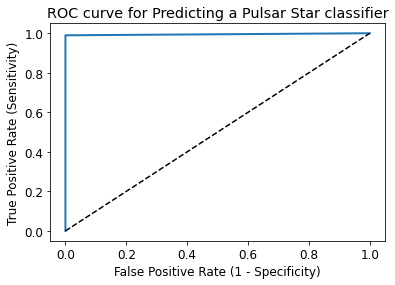

ROC AUC : 0.9948


In [341]:
run_experiment(all_column,6)

In [336]:
finding_hyperparameter(all_column, 'all')

GridSearch CV best score : 0.9940


Parameters that give the best results : 

 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=100, gamma=0.01)


In [331]:
finding_hyperparameter(all_column,5)
finding_hyperparameter(all_column,6)


GridSearch CV best score : 1.0000


Parameters that give the best results : 

 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=10, gamma=0.01)
GridSearch CV best score : 0.9995


Parameters that give the best results : 

 {'C': 1, 'kernel': 'linear'}


Estimator that was chosen by the search : 

 SVC(C=1, kernel='linear')


In [ ]:
finding_hyperparameter(selected_column, 'all')
GridSearch CV best score : 0.9036
Parameters that give the best results : 
 {'C': 10, 'gamma': 0.8, 'kernel': 'rbf'}
Estimator that was chosen by the search : 
 SVC(C=10, gamma=0.8)


finding_hyperparameter(all_column, 1)
GridSearch CV best score : 0.9964
Parameters that give the best results : 
 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Estimator that was chosen by the search : 
 SVC(C=100, gamma=0.001)

In [229]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names,top=-1):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()



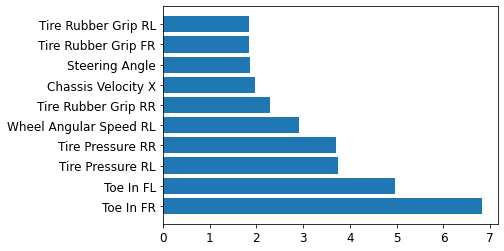

In [248]:
f_importances(abs(svm_model.coef_[0]), all_column, top=10)